# Machine Learning Foundation

## Course 3, Part b: K-Nearest Neighbor LAB


## Introduction and Learning Goals

In this lab, we will explore classification using the K-Nearest Neighbors approach. So this original workbook from this lab downloaded the preprocessed .csv file, so I decided to work through the lab using a different dataset sourced from kaggle.

Name: Telco Customer Churn Dataset \
Source: kaggle \
Url: https://www.kaggle.com/datasets/blastchar/telco-customer-churn


In [39]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

## Question 1

* We begin by importing the data. Examine the columns and data.
* Notice that the data contains a unique ID, an indicator for phone customer status, total lifetime value, total revenue, and a bank-estimated churn score. We will not be using these features, so they can be dropped from the data.
* Begin by taking an initial look at the data, including both numeric and non-numeric features.


In [41]:
df = pd.read_csv("../../core_data/telco_customer_churn.csv")

In [42]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [43]:
df.drop('customerID', axis=1, inplace=True)

In [44]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [45]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [46]:
df.columns = [col.lower() for col in df.columns]
df.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [47]:
df.isna().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

No missing data. Good start. No I'm going to check if any object values are empty strings, as these will need to be removed.

In [48]:
df.eq(' ').sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

Looks like there are some empty string values for total charges. There are only 11 so we can safely drop these columns.

In [49]:
df['totalcharges'].replace(' ', np.nan, inplace=True)
df.dropna(inplace=True)

In [50]:
df.eq(' ').sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

Finally need to convert totalcharges to floats so we can continue with the preprocessing later.

In [51]:
df['totalcharges'] = df['totalcharges'].astype(float)
df['totalcharges'].dtypes

dtype('float64')

In [52]:
df.describe()

,seniorcitizen,tenure,monthlycharges,totalcharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [53]:
Y_COLUMN = 'churn'

I'm also going to engineer the churn column to binary from object.

In [54]:
df[Y_COLUMN].unique()

array(['No', 'Yes'], dtype=object)

In [55]:
df[Y_COLUMN].replace(to_replace={'YES': 1, 'NO': 0}, inplace=True)
df[Y_COLUMN].unique()

array(['No', 'Yes'], dtype=object)

## Question 2

* Identify which variables are binary, categorical and not ordinal, categorical and ordinal, and numeric.  The non-numeric features will need to be encoded using methods we have discussed in the course.
* Start by identifying the number of unique values each variable takes, then create list variables for categorical, numeric, binary, and ordinal variables. 
* Note that the variable 'months' can be treated as numeric, but it may be more convenient to transform it to an ordinal variable.
* For the other categorical variables, examine their values to determine which may be encoded ordinally.


### Binary Columns

There seem to be a number of columns whose values are recorded as objects, but could be Binary Encoded.

In [56]:
df_uniques = pd.DataFrame([[col, len(df[col].unique())] for col in df.columns], columns=['Variable', 'Count']).set_index('Variable')
df_uniques

,Count
Variable,
gender,2
seniorcitizen,2
partner,2
dependents,2
tenure,72
phoneservice,2
multiplelines,3
internetservice,3
onlinesecurity,3


Based on the above breakdown, it looks like the categorical column value_counts sit between 3 and 4, and the rest are numerical which will need to be normalized via scaling.

### Binary Column Generation

In [57]:
binary_columns = [col for col in df.columns if len(df[col].unique()) == 2 and col != Y_COLUMN]
binary_columns

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'paperlessbilling']

### Categorical Column Generation

In [58]:
categorical_columns = [col for col in df.columns if(len(df[col].unique()) > 2 and len(df[col].unique()) <= 4)]
categorical_columns

['multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paymentmethod']

In [59]:
df[categorical_columns]

,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paymentmethod
0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check
1,No,DSL,Yes,No,Yes,No,No,No,One year,Mailed check
2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check
3,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,Bank transfer (automatic)
4,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check
...,...,...,...,...,...,...,...,...,...,...
7038,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Mailed check
7039,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Credit card (automatic)
7040,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Electronic check
7041,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Mailed check


### Numerical Column Generation

In [60]:
numerical_columns = [col for col in df.columns if col not in binary_columns and col not in categorical_columns and col != Y_COLUMN]
numerical_columns

['tenure', 'monthlycharges', 'totalcharges']

In [61]:
assert len(binary_columns) + len(categorical_columns) + len(numerical_columns) + 1 == len(df.columns)

In [62]:
df[numerical_columns].dtypes

tenure              int64
monthlycharges    float64
totalcharges      float64
dtype: object

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'monthlycharges'}>],
       [<Axes: title={'center': 'totalcharges'}>, <Axes: >]], dtype=object)

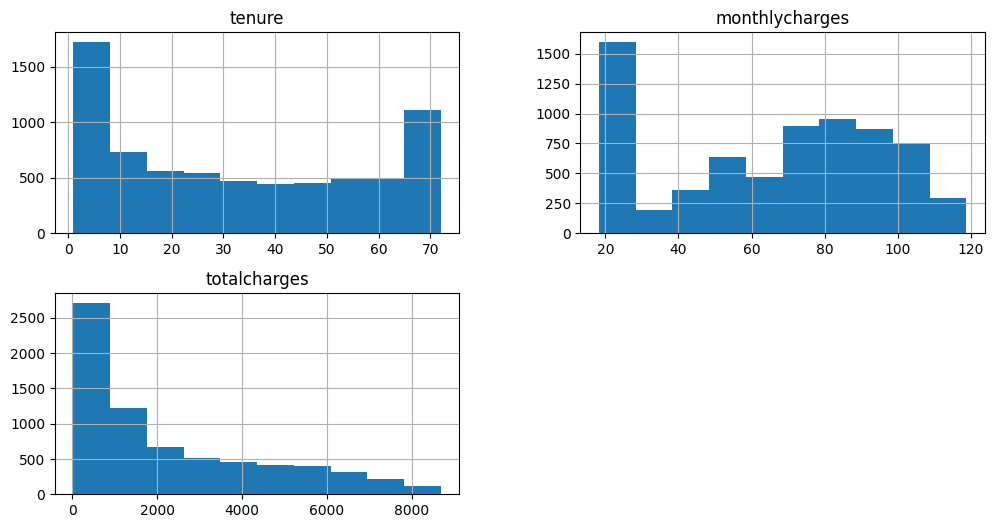

In [63]:
df[numerical_columns].hist(figsize=(12, 6))

These will need to be normalized within the column transformer.

## Question 3
* Having set up the variables, remember that the K-nearest neighbors algorithm uses distance and hence requires scaled data. 
* Scale the data using one of the scaling methods discussed in the course.
* Save the processed dataframe as a comma-separated file: 'churndata_processed.csv'


In [64]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [74]:
categorical_transformer = Pipeline(
    steps=[
        ('cs', OneHotEncoder())
    ]
)

In [75]:
binary_transformer = Pipeline(
    steps=[
        ('bs', LabelBinarizer())
    ]
)

In [76]:
numerical_transformer = Pipeline(
    steps=[
        ('ns', MinMaxScaler())
    ]
)

In [78]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, categorical_columns),
        ('numerical_transformer', numerical_transformer, numerical_columns),
        ('binary_transformer', binary_transformer, binary_columns)
    ]
)

## Question 4
* Now that the data are encoded and scaled, separate the features (X) from the target (y, churn_value). 
* Split the sample into training and test samples, with the test sample representing 40% of observations.
* Estimate a K-Nearest Neighbors model, using K=3.
* Examine the Precision, Recall, F-1 Score, and Accuracy of the classification.
* Use a graphic to illustrate the Confusion Matrix. 


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [81]:
y = df[Y_COLUMN]
X = df.drop(Y_COLUMN, axis=1)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [83]:
model_1 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=3))
    ]
)

In [84]:
model_1.fit(X_train, y_train)

TypeError: LabelEncoder.fit_transform() takes 2 positional arguments but 3 were given